# Example of MCMC run

In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
import HDF5
using BenchmarkTools

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools
using DSP

In [3]:
# using Revise
using Random123
using BAT 

In [4]:
# ENV["JULIA_DEBUG"] = "BAT"

# Load Data

In [5]:
function trunc_norm(m, sgm; alpha=2)
    minval = m - alpha*sgm < 0.0 ? 0.0 : m - alpha*sgm
    return truncated(Normal(m, sgm), minval, m + alpha*sgm)
end

trunc_norm (generic function with 1 method)

## 1.1 Low `p` Population: 

In [6]:
# conv_mat = load("../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2")

# conv_matrices = (
#     cam_1 = conv_mat["cam_1"],
#     cam_2 = conv_mat["cam_2"],
#     cam_3 = conv_mat["cam_3"],
#     cam_4 = conv_mat["cam_4"], 
# )

# images = load("../data/experiment/dataset_2/m1/images-satur.jld2");
# event_number = 343

# # Small Charge: Ev_1_3 = 343, Ev_1_1 = 137, Ev_1_2 = 9

# event = (
#     cam_1 = images["cam_1"][event_number,:,:],
#     cam_2 = images["cam_2"][event_number,:,:],
#     cam_3 = images["cam_3"][event_number,:,:],
#     cam_4 = images["cam_4"][event_number,:,:],
#     population = images["charge"][event_number,:][1],
# );

## 1.2 High `p` Population: 

In [7]:
conv_mat = load("../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
) 

images = load("../data/experiment/dataset_2/m2/images-satur.jld2"); # removed saturated pixels
# images = load("../data/experiment/dataset_2/m2/images.jld2"); # included saturated pixels
event_number = 2

# Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


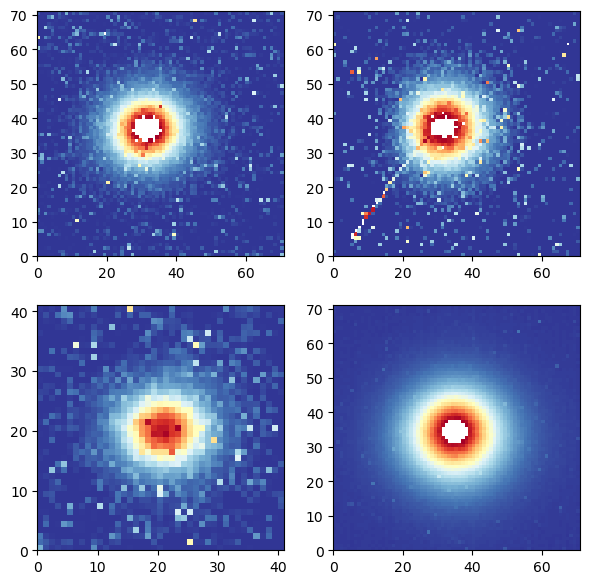

PyObject <matplotlib.collections.QuadMesh object at 0x7fa4dc046220>

In [8]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

# Load Model

## Model 35: 

In [36]:
include("../src/model-35-sym/likelihood.jl")
include("../src/model-35-sym/utill_model.jl")
include("../src/utill.jl")

plot_projections (generic function with 1 method)

In [11]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058 

prior = NamedTupleDist(
    tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19),],
    ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), ],
    waist = [truncated(Normal(2.774, 0.03), 2.5, 3.6),],
    algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    cam4_ped = 4.0 .. 40.0,
    cam4_light_fluct = 1.0 .. 3.0,
    cam4_light_amp = 1.6 .. 9.9, 
    resx = [1.0, 1.0, 1.0], 
    resy = [1.0, 1.0, 1.0], 
    cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
    cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
    psx = [27.1, 21.6, 114.0], # 31, 32, 33
    psy = [30.5, 23.4, 125.0], # 34, 35, 36
    cam4_psx = 121.8, # 37
    cam4_psy = 120.0, # 38
    light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
    s_cam = [0.0, 1.478, 15.026, 23.1150],
);  # works 

# MCMC settings: 

In [12]:
"""
    Log-Likelihood of the beamline (4 cameras included)
"""
function log_lik_ndiff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_discrete,
    cv_1 = cv_mat.cam_1,
    cv_2 = cv_mat.cam_2,
    cv_3 = cv_mat.cam_3,
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
        
end

function log_lik_diff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_cont,
    cv_1 = exp.(cv_mat.cam_1),
    cv_2 = exp.(cv_mat.cam_2),
    cv_3 = exp.(cv_mat.cam_3),
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
    
end

# log_likelihood = log_lik_diff()

log_likelihood = log_lik_ndiff()

#54 (generic function with 1 method)

In [13]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

mcmcalgo = MetropolisHastings(
    weighting = RepetitionWeighting(),
    tuning = tuning
)

rng = Philox4x()

init = MCMCChainPoolInit(
    init_tries_per_chain = 50 .. 150,
    nsteps_init = 1500
)

burnin = MCMCMultiCycleBurnin(
    max_ncycles = 160,
    nsteps_per_cycle = 40000
)

nsamples = 5*10^5
nchains = 4

convergence = BrooksGelmanConvergence(threshold=1.15);

In [14]:
@time samples_tot = bat_sample(
    rng, posterior,
    MCMCSampling(
        mcalg = mcmcalgo,
        trafo = NoDensityTransform(),
        nchains = nchains,
        nsteps = nsamples,
        init = init,
        burnin = burnin,
        convergence = convergence,
        strict = false,
#         store_burnin = false,
#         nonzero_weights = true,
    )
);

┌ Info: Using tranform algorithm DensityIdentityTransform()
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 4 finished, 4

1180.717055 seconds (4.92 G allocations: 2.781 TiB, 29.01% gc time, 0.00% compilation time)


In [15]:
samples = samples_tot.result;

In [16]:
minimum(bat_eff_sample_size(unshaped.(samples)).result)

651.5173059630458

In [17]:
size(flatview(unshaped.(samples.v)))

(19, 503436)

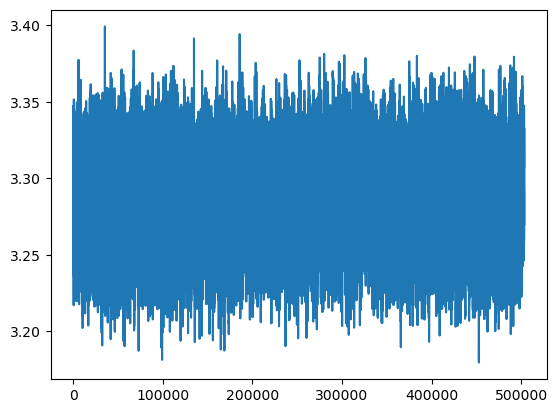

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa41a8132b0>

In [18]:
plot(flatview(unshaped.(samples.v))[3,:])

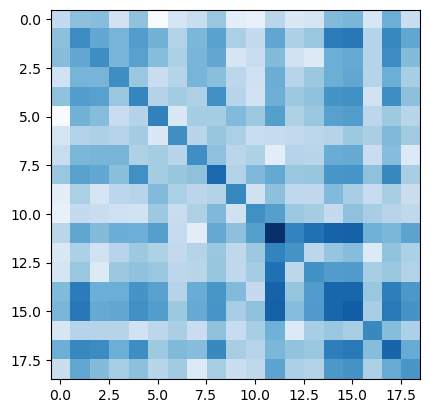

PyObject <matplotlib.image.AxesImage object at 0x7fa41a7f06a0>

In [19]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [20]:
# BAT.bat_write("../data/sampling_results/Tmp-Mixture-Model-38-2/mm-38-hc-2-fixed-lf.hdf5", unshaped.(samples))

# BAT.bat_write("../data/sampling_results/Benchmark-14/samples-res-upd.hdf5", unshaped.(samples))

In [21]:
mode(samples)[1]

(tr_size = [0.11821128660746136], ang_spr = [4.722707507503551], waist = [3.2674951071771017], algmx = [31.747472202386426, 32.44589568235307, 21.267642680253363, 35.266573405117185], algmy = [36.918308066757895, 37.590171856179, 20.19445624044041, 33.84491403855263], cam4_ped = 33.743373442584016, cam4_light_fluct = 2.006484709599958, cam4_light_amp = 8.393680871501434, resx = [1.0, 1.0, 1.0], resy = [1.0, 1.0, 1.0], cam4_resx = 5.468183975976868, cam4_resy = 4.448519912196441, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.276746072609674, 11.05541079397096, 2.5345728128166365], s_cam = [0.0, 1.478, 15.026, 23.115])

In [22]:
bat_marginalmode(samples).result

ShapedAsNT((tr_size = [0.11785000000000001], ang_spr = [4.7305], waist = [3.2794999999999996], algmx = [31.744500000000002, 32.441, 21.277, 35.2545], algmy = [36.926500000000004, 37.5975, 20.215, 33.8455], cam4_ped = 33.629999999999995, cam4_light_fluct = 2.0035, cam4_light_amp = 8.401499999999999, resx = [1.0, 1.0, 1.0], resy = [1.0, 1.0, 1.0], cam4_resx = 5.467499999999999, cam4_resy = 4.4775, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.283000000000001, 10.9825, 2.5545], s_cam = [0.0, 1.478, 15.026, 23.115]))

In [23]:
mean(samples)[1]

(tr_size = [0.11687568614191095], ang_spr = [4.7375066301729145], waist = [3.2837029889186597], algmx = [31.746987627061944, 32.44484732600922, 21.271457423754786, 35.25758718220209], algmy = [36.934240690482994, 37.57521984346666, 20.212869031167727, 33.842539099283755], cam4_ped = 33.581515936915416, cam4_light_fluct = 2.00354956347414, cam4_light_amp = 8.40157032196788, resx = [1.0, 1.0, 1.0], resy = [1.0, 1.0, 1.0], cam4_resx = 5.454993394429604, cam4_resy = 4.4621847398481895, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.28751730155805, 11.024133554685246, 2.552483585759035], s_cam = [0.0, 1.478, 15.026, 23.115])

In [24]:
std(samples)[1]

(tr_size = [0.0017214708599640684], ang_spr = [0.025084612036655938], waist = [0.023472366119697677], algmx = [0.023234057882426225, 0.02916548424685582, 0.032554786761007, 0.023215890562184045], algmy = [0.023271799993938695, 0.06113626418774684, 0.027811770927447414, 0.02252154783839583], cam4_ped = 0.278388157058159, cam4_light_fluct = 0.020358751779917243, cam4_light_amp = 0.022084771896589143, resx = 3-element Fill{Float64}: entries equal to 0.0, resy = 3-element Fill{Float64}: entries equal to 0.0, cam4_resx = 0.06731904970252552, cam4_resy = 0.08188712539812087, psx = 3-element Fill{Float64}: entries equal to 0.0, psy = 3-element Fill{Float64}: entries equal to 0.0, cam4_psx = 0.0, cam4_psy = 0.0, light_amp = [0.02687015359605425, 0.067488585078216, 0.018277409388290176], s_cam = 4-element Fill{Float64}: entries equal to 0.0)

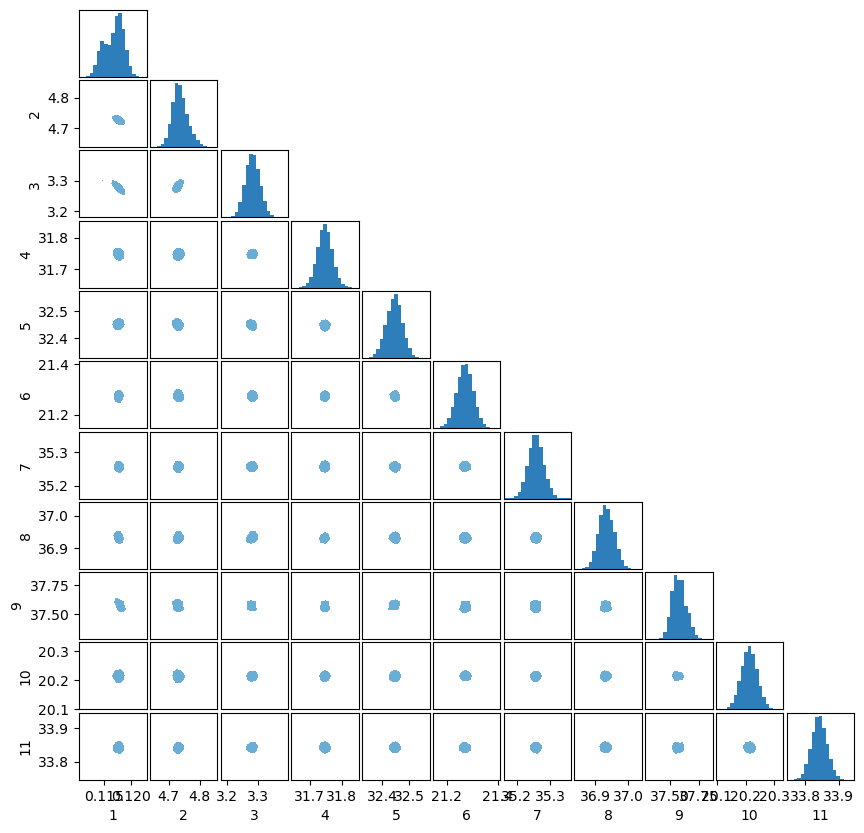

In [25]:
dims = [1,2,3,4,5,6,7,8,9,10,11]
# dims = [1,2,3,4,5,]
names = [1,2,3,4,5,6,7,8,9,10, 11]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

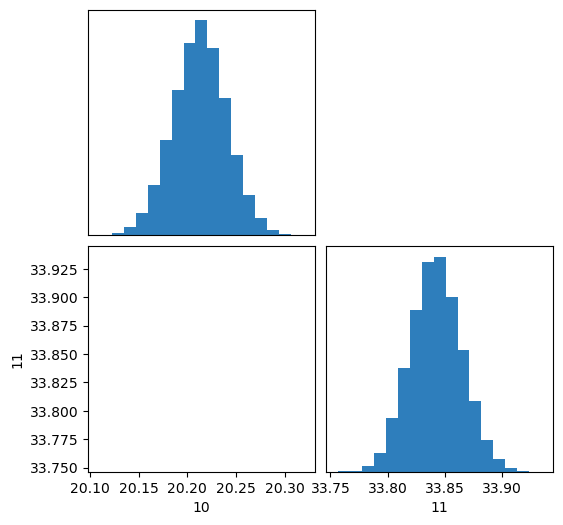

In [26]:
dims = [10,11,]
names = [10,11,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.1,  1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

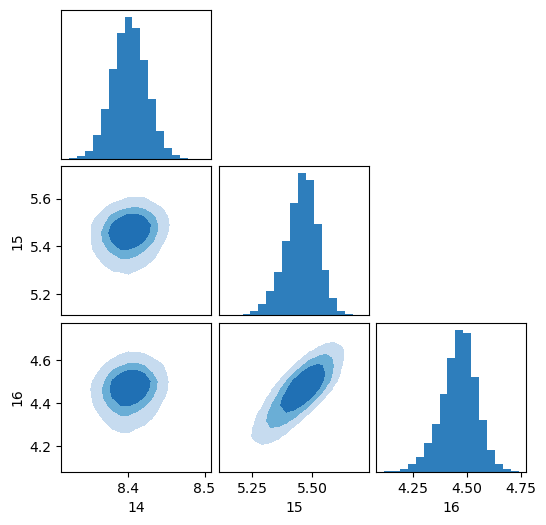

In [27]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [28]:
# res

dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.5, 0.9, 0.95,  1,]
levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 19×503436 ElasticArrays.ElasticMatrix{Float64, 1, Vector{Float64}} at index [20, 1:503436]

In [29]:
#pix

dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
levels = [0.1, 0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 19×503436 ElasticArrays.ElasticMatrix{Float64, 1, Vector{Float64}} at index [25, 1:503436]

In [30]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 19×503436 ElasticArrays.ElasticMatrix{Float64, 1, Vector{Float64}} at index [33, 1:503436]

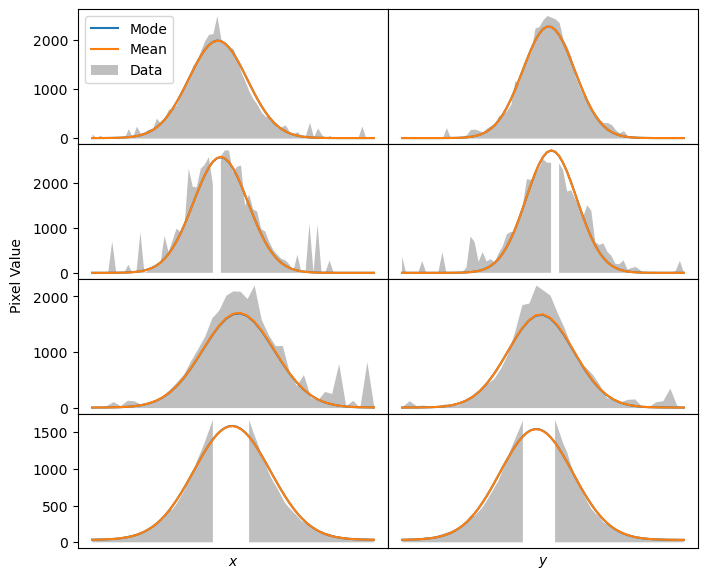

PyObject Text(0.04, 0.5, 'Pixel Value')

In [37]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

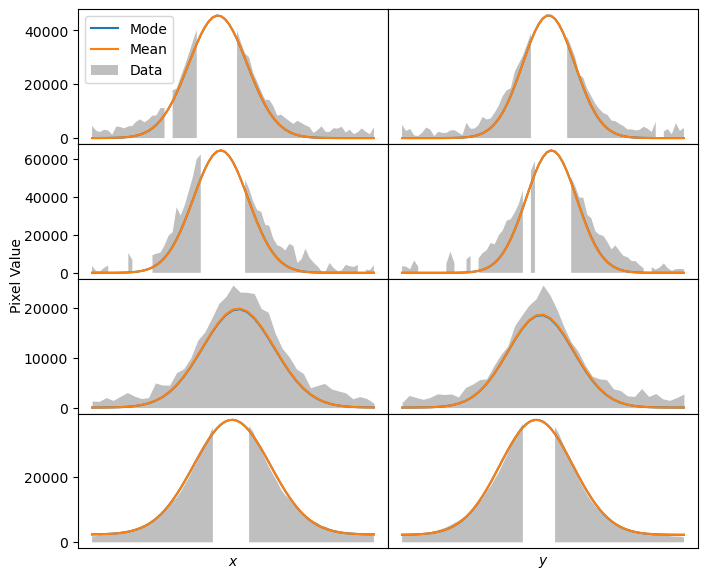

PyObject Text(0.04, 0.5, 'Pixel Value')

In [38]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

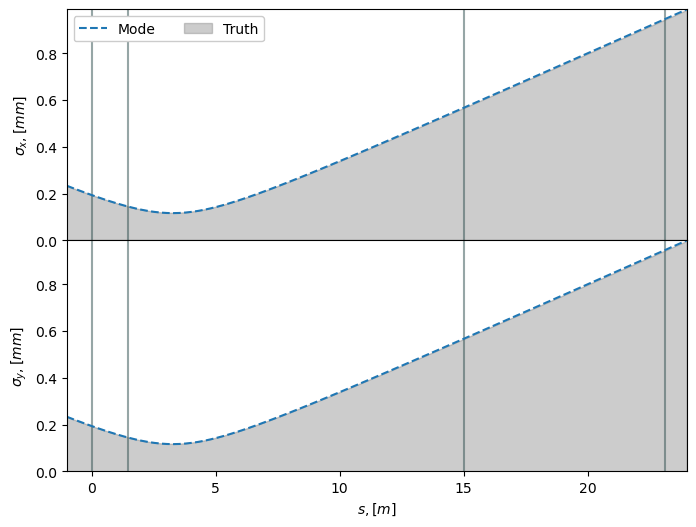

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [39]:
params_array = [mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [40]:
images = load("../data/experiment/dataset_2/m2/images.jld2")
event_ns = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

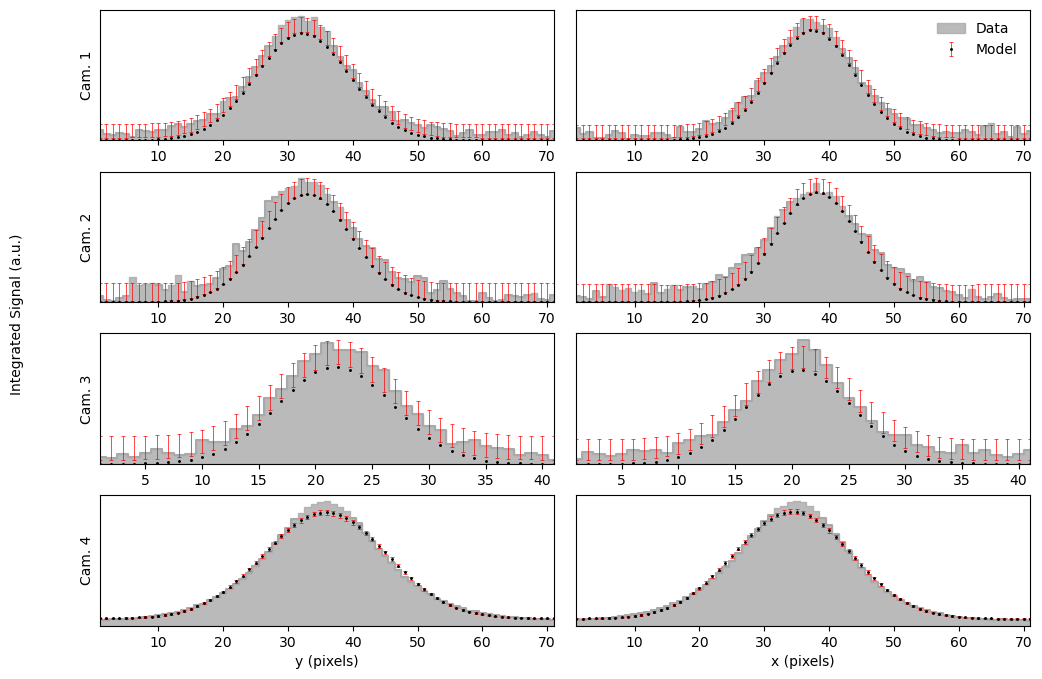

In [41]:
plot_projections(conv_matrices, event_ns, event, params_array[1], isnontr = true)

In [42]:
# try model 38 with light fluctuations constant on the IS2
# fixe resolution in the IS2 amera